# Benchmarks

Timings reported in paper

In [1]:
%env http_proxy=http://proxyserv:3128
%env https_proxy=http://proxyserv:3128

env: http_proxy=http://proxyserv:3128
env: https_proxy=http://proxyserv:3128


In [2]:
%load_ext rpy2.ipython

from IPython.display import Image
from graphviz import Digraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

In [3]:
%%R
# install.packages("matrixdist")
# install.packages("expm")

NULL


In [4]:
%%R
# remove.packages("PhaseTypeR")
# install.packages("PhaseTypeR")

NULL


In [5]:
%%R
#remove.packages("PhaseTypeR")
#devtools::install_github("kaspermunch/PhaseTypeR")

NULL


In [6]:
%%R
devtools::install_github("TobiasRoikjer/PtDAlgorithms")
library(ptdalgorithms)

set.seed(7)

R[write to console]: Skipping install of 'ptdalgorithms' from a github remote, the SHA1 (29809aeb) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
%%R
library(ptdalgorithms)
library(PhaseTypeR)
library(matrixdist)
library(expm)
library(ggplot2)

R[write to console]: Indlæser krævet pakke: expm

R[write to console]: Indlæser krævet pakke: Matrix

R[write to console]: 
Vedhæfter pakke: ‘expm’


R[write to console]: Det følgende objekt er maskeret fra ‘package:Matrix’:

    expm


R[write to console]: Indlæser krævet pakke: matrixdist

R[write to console]: Indlæser krævet pakke: igraph

R[write to console]: 
Vedhæfter pakke: ‘igraph’


R[write to console]: De følgende objekter er maskerede fra ‘package:ptdalgorithms’:

    edges, vertices


R[write to console]: De følgende objekter er maskerede fra ‘package:stats’:

    decompose, spectrum


R[write to console]: Det følgende objekt er maskeret fra ‘package:base’:

    union


R[write to console]: 
Vedhæfter pakke: ‘PhaseTypeR’


R[write to console]: Det følgende objekt er maskeret fra ‘package:Matrix’:

    mean


R[write to console]: Det følgende objekt er maskeret fra ‘package:stats’:

    var


R[write to console]: Det følgende objekt er maskeret fra ‘package:base’:

    mean


Function for plotting running times:

In [4]:
def runtime_plot(plot_df, x_labels, y_label, hue_label, 
                 colors=['#FF0000', '#2901F7', '#05BFC0'], 
                 legend=True, legend_title=True):
    # with sns.color_palette(colors):
    with sns.color_palette("Set1"):
        gs_kw = dict(height_ratios=[50] + [1]*(len(x_labels)-1))
        fig, axes = plt.subplots(len(x_labels), 1, figsize=(5, 5), gridspec_kw=gs_kw)

        sns.scatterplot(data=plot_df, x=x_labels[0], y=y_label, hue=hue_label, legend=False, ax=axes[0])    
        ax = sns.lineplot(data=plot_df, x=x_labels[0], y='seconds', hue=hue_label, ax=axes[0])
        # ax.set_yscale('log')

        if not legend_title:
            legend = axes[0].legend()
            legend.set_title("")
        
        leg = ax.get_legend()
        leg.get_frame().set_linewidth(0.0)
        
        if not legend:
            axes[0].get_legend().remove()

        sns.despine()

        for i in range(1, len(x_labels)):
            ax = sns.scatterplot(data=plot_df, x=x_labels[i], y=y_label, hue=hue_label, legend=False, ax=axes[i], alpha=0) 
            axes[i].get_yaxis().set_visible(False)
        plt.tight_layout()
    return fig, axes

Compile function for constructing rabbit model in C:

In [5]:
%%R
Rcpp::sourceCpp("rabbit_construction.cpp")

Compile function for constructing the coalescent in C:

In [6]:
%%R
Rcpp::sourceCpp("kingman.cpp")

Function for parallel computing:

In [7]:
%%R 

library(parallel)

#cores = 4L
cores = Sys.getenv("SLURM_CPUS_PER_TASK") # or something...

# # producing a matrix
# apply_grid <- function(fun, a, b) {
#     named_params <- expand.grid(a, b)
#     param_list <- split(named_params, seq(nrow(named_params)))    
#     result_list <- mclapply(param_list, function(x) do.call(fun, as.list(as.vector(unlist(x)))), mc.cores=cores)
#     mat <- array(unlist(result_list), dim = c(2, length(a),length(b)))
#     return(mat)
# }
# fun <- function(i, var) {    
#     return(c(i, var))
# }

# producing a dataframe
apply_grid <- function(fun, a, b) {
    named_params <- expand.grid(a, b)
    param_list <- split(named_params, seq(nrow(named_params)))    
    result_list <- mclapply(param_list, function(x) do.call(fun, as.list(as.vector(unlist(x)))), mc.cores=cores)
    return(do.call(rbind, result_list))
}
# fun <- function(i, var) {    
#     return(as.data.frame(cbind(k=i, munch=var)))
# }


# Construction time 

In [14]:
%%R
construct_rabbit_graph_R <- function(number_of_rabbits, flooding_rate_l, flooding_rate_r) {
    # We represent the vector as two integers, the number of rabbits on the left and right island
    state_vector_length <- 2
    graph <- create_graph(state_vector_length)
    initial_state <- c(number_of_rabbits, 0)
    # The initial state is the only starting state, with 100% starting probability
    add_edge(
      starting_vertex(graph),
      find_or_create_vertex(graph, initial_state),
      1
    )
    index <- 2
    # Iterate over all unvisited vertices
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      state <- vertex$state
      if (state[1] > 0) {
        # Rabbit jump left to right
        child_state <- c(state[1] - 1, state[2] + 1)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          1
        )

        # Left island flooding
        child_state <- c(0, state[2])
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          flooding_rate_l
        )
      }

      if (state[2] > 0) {
        # Rabbit jump right to left
        child_state <- c(state[1] + 1, state[2] - 1)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          1
        )
        # Right island flooding with rate of 4
        child_state <- c(state[1], 0)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          flooding_rate_r
        )
      }
      index <- index + 1
    }
    return(graph)
}

In [19]:
%%R -o construction_df
RABBIT_NUMBERS <- seq(50, 1000, 50)
construction_df <- data.frame()

for (i in 1:1) { # change this back to 1:10
    for (rabbits in RABBIT_NUMBERS) {
        time_R <- NA
        if (rabbits <= 500) {
            start <- proc.time()[3]            
            construct_rabbit_graph_R(rabbits, 2, 4)
            end <- proc.time()[3]
            time_R <- end-start
        } 
        
        start <- proc.time()[3]
        graph <- construct_rabbit_graph(rabbits, 2, 4)
        end <- proc.time()[3]
        time_c = end-start
        
        time_from_matrix <- NA
        if (rabbits <= 150) {
            M <- graph_as_matrix(graph)
            start <- proc.time()[3]
            mat <- matrix_as_graph(M$IPV, M$SIM)
            end <- proc.time()[3]
            time_from_matrix = end-start
        }

        construction_df <- rbind(construction_df, list(rabbits=rabbits, 
                                                       time_c=time_c, 
                                                       time_R=time_R, 
                                                       time_from_matrix=time_from_matrix,
                                                       vertices=vertices_length(graph), 
                                                       edges=number_of_edges(graph)))
    }
}

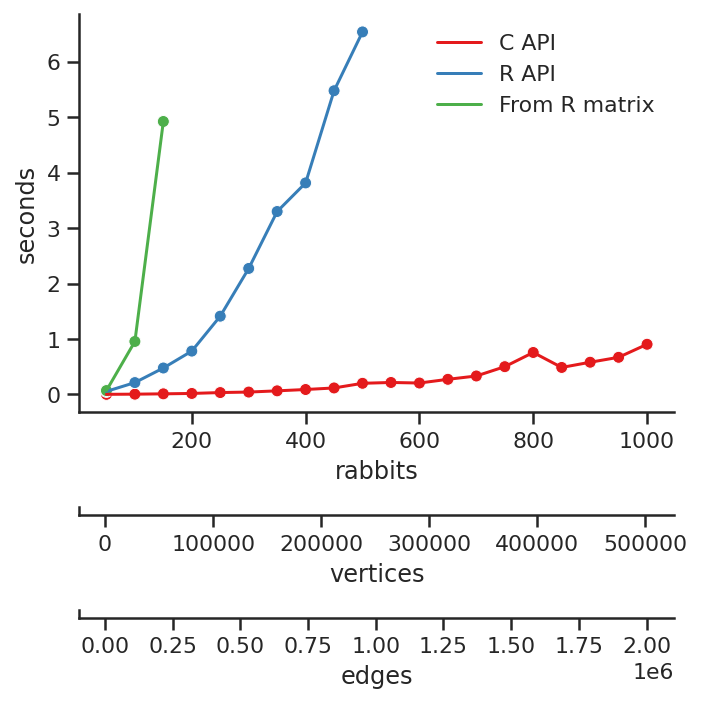

In [20]:
construction_df.loc[construction_df.time_R > 500, 'time_R'] = np.nan
plot_df = (construction_df.groupby(['rabbits', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'time_c': 'C API', 'time_R': 'R API', 'time_from_matrix': 'From R matrix'})
 .melt(id_vars=['rabbits', 'vertices', 'edges'], value_name='seconds', var_name='API')
)

runtime_plot(plot_df, ['rabbits', 'vertices', 'edges'], 'seconds', 'API', 
            legend_title=False)
plt.savefig('figures/rabbit_construction.pdf')

# Computation

## Parameters

In [8]:
%run benchmarks_rabbits_params.ipy
# %run benchmarks_kingman_params.ipy
# %run benchmarks_coxian_params.ipy

In [8]:
# %%R -o units -o label -o expectation_max_construction_values_for_matrix -o moments100_max_construction_values_for_matrix -o cdf100_max_construction_values_for_matrix
# construction_fun <- function(x) {
#     return(construct_rabbit_graph(x, 2, 4))
# }
# units <- "rabbits"
# label <- "rabbits"
# expectation_construction_values <- c(10, 20, 30, 40)#, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500)
# expectation_max_construction_values_for_matrix <- 100
# moments100_construction_values <- c(10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500)
# moments100_max_construction_values_for_matrix <- 100
# cdf100_construction_values <- c(10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300)
# cdf100_max_construction_values_for_matrix <- 60

In [8]:
# %%R -o units -o label -o expectation_max_construction_values_for_matrix -o moments100_max_construction_values_for_matrix -o cdf100_max_construction_values_for_matrix
# construction_fun <- function(x) {
#     return(generate_kingman_graph(x, x))
# }
# units <- "samples"
# label <- "coalescent"
# expectation_construction_values <- seq(4, 60, 2)
# expectation_max_construction_values_for_matrix <- 30
# moments100_construction_values <- seq(4, 40, 2)
# moments100_max_construction_values_for_matrix <- 20
# cdf100_construction_values <- seq(4, 40, 2)
# cdf100_max_construction_values_for_matrix <- 22

In [137]:
# %%R -o units -o label -o expectation_max_construction_values_for_matrix -o moments100_max_construction_values_for_matrix -o cdf100_max_construction_values_for_matrix
# construction_fun <- function(x) {
#     graph <- create_graph(1)
#     s <- create_vertex(graph,1)
#     a <- create_vertex(graph,1)
#     add_edge(starting_vertex(graph),s , 1)
#     set.seed(1234)
#     for (i in 1:x) {
#         n <- create_vertex(graph, 1); 
#         k <- runif(1); 
#         l <- runif(1) * k; 
#         add_edge(n,s,k); 
#         add_edge(n,a,l);
#         s <- n
#     }
#     return(graph)
# }
# units <- "dimension"
# label <- "coxian"
# expectation_construction_values <- seq(4, 40, 2)
# expectation_max_construction_values_for_matrix <- 20
# moments100_construction_values <- seq(4, 40, 2)
# moments100_max_construction_values_for_matrix <- 20
# cdf100_construction_values <- seq(4, 40, 2)
# cdf100_max_construction_values_for_matrix <- 22

In [138]:
# %%R
# dim <- 30
# graph <- construction_fun(dim)
# mat <- graph_as_matrix(graph)
# graph <- matrix_as_graph(c(1,rep(0, dim-1)), mat$SIM)
# mat <- graph_as_matrix(graph)
# #mat

In [139]:
# %%R
# system.time(expectation(graph))

In [140]:
# %%R
# # matrixdist_ph <- matrixdist::ph(alpha=mat$IPV, S=mat$SIM, structure="coxian",dimension=dim)
# matrixdist_ph <- matrixdist::ph(alpha=mat$IPV, S=mat$SIM)
# system.time(matrixdist::moment(matrixdist_ph, 1))

In [13]:
%%R
graph <- construction_fun(500)
system.time(ptdalgorithms::expectation(graph))

INFO: building reward compute graph...


  bruger   system forløbet 
   3.615    1.646    5.449 


In [11]:
%%R
graph <- construction_fun(100)
M <- graph_as_matrix(graph)
Y <- PH(M$SIM, M$IPV)            
system.time(PhaseTypeR::mean(Y))

  bruger   system forløbet 
  28.000    2.643    5.291 


----

Make python string vars:

In [15]:
things = str(units[0])
label = str(label[0])

## Compare base::solve() against matrixdist:::matrix_inverse()

In [18]:
%%R -o base_times -o matrixdist_times
base_times <- c()
matrixdist_times <- c()
for (val in expectation_construction_values) {
    if (val <= expectation_max_construction_values_for_matrix) {
        graph <- construction_fun(val)
        mat <- graph_as_matrix(graph)$SIM
        base_times <- c(base_times, system.time(MI1 <- base::solve(mat))[3])
        matrixdist_times <- c(matrixdist_times, system.time(MI2 <- matrixdist:::matrix_inverse(mat))[3])
    }
}

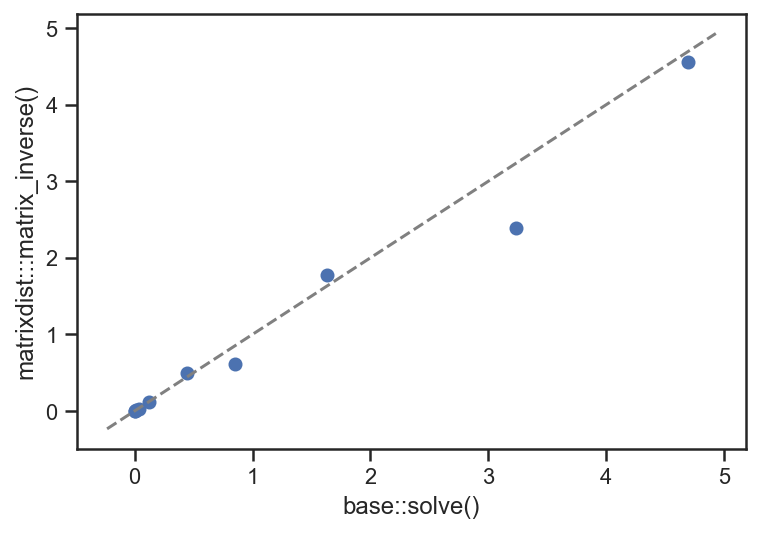

In [19]:
def abline(slope, intercept, ax=None):
    "Add a straight line through the plot"
    if ax is None:
        ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='grey')
    
plt.scatter(base_times, matrixdist_times)
plt.xlabel('base::solve()')
plt.ylabel('matrixdist:::matrix_inverse()')
abline(1, 0)
plt.savefig(f'figures/inversion_test_{str(label[0])}.pdf')   

## Test methods for exponentiation with expm()

In [20]:
%%R -o expm_tests_all_methods
#EXPM  tests, ALL methods!

results <- data.frame()
for (val in expectation_construction_values){
    if (val <= expectation_max_construction_values_for_matrix) {
        for (method in c("Higham08.b", "Higham08", "AlMohy-Hi09", "Ward77", "PadeRBS", 
                         # "Pade", "PadeO", "TaylorO", .. the slowest ones
                         # "R_Eigen",   ... does not work with rabbits
                         "Taylor", "R_Pade", "R_Ward77", "hybrid_Eigen_Ward")) {

            graph <- construction_fun(val)
            mat <- graph_as_matrix(graph)$SIM
            start <- proc.time()[3]
            expm(mat, method=method)
            stop <- proc.time()[3]
            time_spent_exp <- stop - start

            results <- rbind(results, data.frame(val=val,
                                                 vertices=vertices_length(graph),
                                                 edges=number_of_edges(graph),
                                                 time_spent_exp=time_spent_exp,
                                                 method=method))
        }
    }
}

expm_tests_all_methods <- results

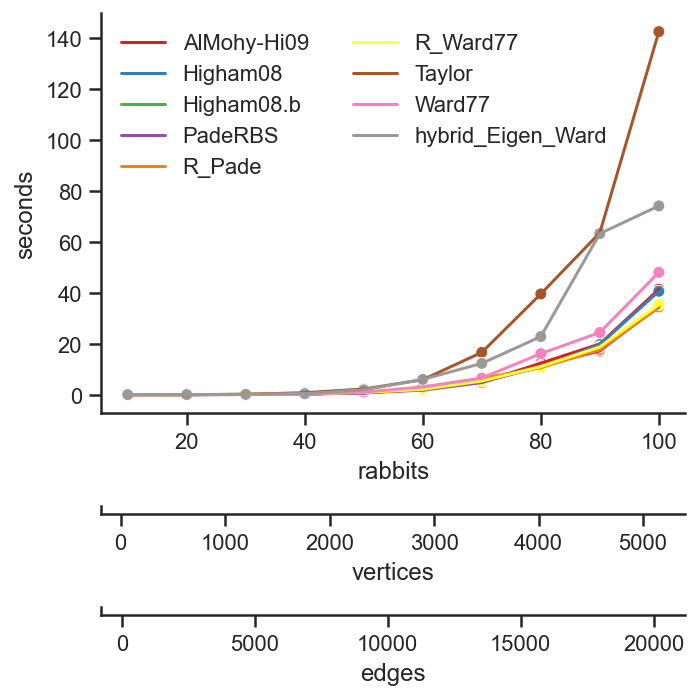

In [21]:
plot_df = (expm_tests_all_methods.groupby(['val', 'vertices', 'edges', 'method'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'time_spent_exp': 'seconds', 'val': str(units[0])})
)
fig, axes = runtime_plot(plot_df, [things, 'vertices', 'edges'], 'seconds', 'method')
axes[0].legend(ncol=2, loc="upper left", framealpha=0)
#axes[0].set_yscale('log')
plt.savefig(f'figures/expm_tests_all_methods_{str(label[0])}.pdf')   

# Expectation

Comparing phasetyper, matrixdist ptdalgorithms.

PhaseTyper uses base::solve() for inversion

Reviewer two says matrixdist::matrix_inverse() is much faster for sparse matrices. However, only some phase-type distributions fit coxian or erlang forms and our tool is a general one. For the phase-type distributions used as mdoels here matrixdist is not faster:



In [9]:
%%R 

expectation_fun <- function(i, val) {
    graph <- construction_fun(val)
    M <- graph_as_matrix(graph)
    phasetyper_time <- NA
    ptdalgorithms_time <- NA
    if (val <= expectation_max_construction_values_for_matrix) {
        Y <- PH(M$SIM, M$IPV)            
        start <- proc.time()[3]
        PhaseTypeR::mean(Y)
        end <- proc.time()[3]
        phasetyper_time <- end - start
    }
    start <- proc.time()[3]
    ptdalgorithms::expectation(graph)
    end <- proc.time()[3]
    ptdalgorithms_time = end-start
    df <- as.data.frame(cbind(val=val, 
                              ptdalgorithms_time=ptdalgorithms_time, 
                              phasetyper_time=phasetyper_time,
                              vertices=vertices_length(graph), 
                              edges=number_of_edges(graph)))
    return(df)
}

moments100_fun <- function(i, val) {
    graph <- construction_fun(val)
    M <- graph_as_matrix(graph)
    phasetyper_time <- NA
    ptdalgorithms_time <- NA
    if (val <= moments100_max_construction_values_for_matrix) {
        Y <- PH(M$SIM, M$IPV)            
        rewards <- rep(1, length(M$IPV))
        start <- proc.time()[3]
        for (i in 1:100) {
           Y <- PhaseTypeR::reward_phase_type(Y, rewards)
           PhaseTypeR::mean(Y)
        }
        end <- proc.time()[3]
        phasetyper_time <- end - start                     
    }
    start <- proc.time()[3]
    rewards <- rep(1, length(rowSums(states(graph))))
    for (i in 1:100) {
       graph <- reward_transform(graph, rewards)
       expectation(graph)
    }
    end <- proc.time()[3]
    ptdalgorithms_time = end-start
    df <- as.data.frame(cbind(val=val, 
                              ptdalgorithms_time=ptdalgorithms_time, 
                              phasetyper_time=phasetyper_time,
                              vertices=vertices_length(graph), 
                              edges=number_of_edges(graph)))
    return(df)
}

cdf100_fun <- function(i, val) {
    graph <- construction_fun(val)
    phasetyper_time <- NA
    ptdalgorithm_time <- NA
    start <- proc.time()[3]
    ptdcdf <- ptdalgorithms::pph(cdf_vals, graph)
    stop <- proc.time()[3]
    ptdalgorithm_time <- stop - start
    if (val <= cdf100_max_construction_values_for_matrix) {
         M <- graph_as_matrix(graph)
        start <- proc.time()[3]
        Y <- PhaseTypeR::PH(M$SIM, M$IPV)
        PhaseTypeR::pPH(cdf_vals, Y)
        stop <- proc.time()[3]
        phasetyper_time <- stop - start
    }
    df <- as.data.frame(cbind(val=val, 
                              ptdalgorithms_time=ptdalgorithms_time, 
                              phasetyper_time=phasetyper_time,
                              vertices=vertices_length(graph), 
                              edges=number_of_edges(graph)))
    return(df)
}


In [10]:
%%R -o expectation_df
expectation_df <- apply_grid(expectation_fun, 1:2, expectation_construction_values)

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...


In [21]:
%%R -o moments100_df
moments100_df <- apply_grid(moments100_fun, 1:2, moments100_construction_values)

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...


In [21]:
%%R -o cdf100_df
cdf100_df <- apply_grid(cdf100_fun, 1:2, cdf100_construction_values)

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...


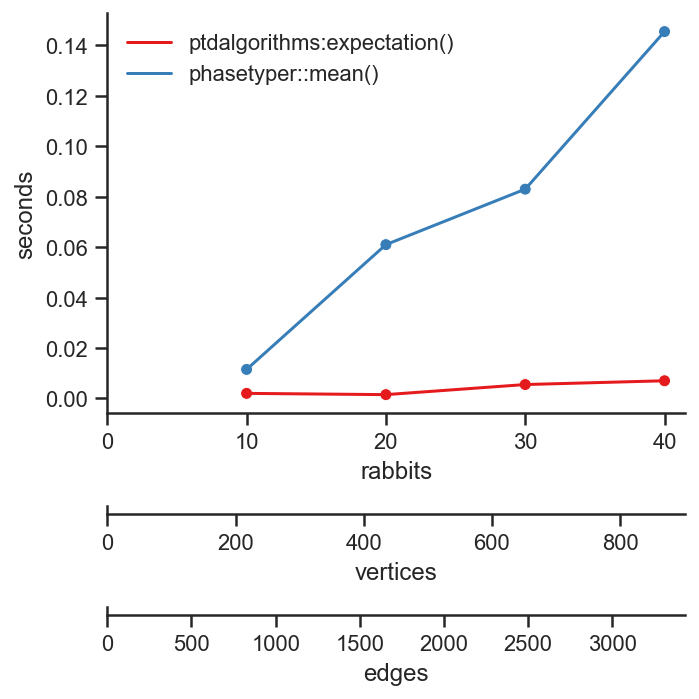

In [22]:
plot_df = (expectation_df.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': str(units[0]),
                  'ptdalgorithms_time': 'ptdalgorithms:expectation()', 
                  'phasetyper_time': 'phasetyper::mean()',
                  'matrixdist_time': 'matrixdist::moment()',
                  'matrixdist_inverse_time': 'matrixdist::inverse_matrix()',
                  'solve_time': 'base::solve()'
                 })
 .melt(id_vars=[things, 'vertices', 'edges'], 
       value_name='seconds', var_name='Method')
)
fig, axes = runtime_plot(plot_df, [str(units[0]), 'vertices', 'edges'],
                         'seconds', 'Method', legend_title=False)
for ax in axes:
    ax.set_xlim(left=0)
plt.savefig(f'figures/expectation_{str(label[0])}.pdf')

In [ ]:
plot_df = (moments100_df.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': str(units[0]),
                  'ptdalgorithms_time': 'ptdalgorithms:expectation()', 
                  'phasetyper_time': 'phasetyper::mean()',
                  'matrixdist_time': 'matrixdist::moment()',
                  'matrixdist_inverse_time': 'matrixdist::inverse_matrix()',
                  'solve_time': 'base::solve()'
                 })
 .melt(id_vars=[things, 'vertices', 'edges'], 
       value_name='seconds', var_name='Method')
)
fig, axes = runtime_plot(plot_df, [str(units[0]), 'vertices', 'edges'],
                         'seconds', 'Method', legend_title=False)
for ax in axes:
    ax.set_xlim(left=0)
plt.savefig(f'figures/moments_100_{str(label[0])}.pdf')

In [ ]:
plot_df = (cdf100_df.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': str(units[0]),
                  'ptdalgorithms_time': 'ptdalgorithms:expectation()', 
                  'phasetyper_time': 'phasetyper::mean()'})
 .melt(id_vars=[things, 'vertices', 'edges'], 
       value_name='seconds', var_name='Method')
)
fig, axes = runtime_plot(plot_df, [str(units[0]), 'vertices', 'edges'],
                         'seconds', 'Method', legend_title=False)
for ax in axes:
    ax.set_xlim(left=0)
#plt.savefig(f'figures/both_distribution_functions_{label}.pdf')

# OLD STUFF

In [ ]:
%%R -o expectation_df

expectation_df <- data.frame()

for (i in 1:1) {   # PUT THIS BACK TO 1:10.......
    for (val in expectation_construction_values) {
        graph <- construction_fun(val)
        M <- graph_as_matrix(graph)

        solve_time <- NA
        matrixdist_inverse_time <- NA
        phasetyper_time <- NA
        matrixdist_time <- NA
        ptdalgorithms_time <- NA
        
        if (val <= expectation_max_construction_values_for_matrix) {
            
            # # base solve
            # start <- proc.time()[3]
            # base::solve(M$SIM)
            # end <- proc.time()[3]
            # solve_time <- end - start

            # # matrix inversion from matrixdist
            # start <- proc.time()[3]
            # matrixdist:::matrix_inverse(M$SIM)
            # end <- proc.time()[3]
            # matrixdist_inverse_time <- end - start

            # phasetyper
            Y <- PH(M$SIM, M$IPV)            
            start <- proc.time()[3]
            PhaseTypeR::mean(Y)
            end <- proc.time()[3]
            phasetyper_time <- end - start
            
            # # matrixdist
            # matrixdist_ph <- matrixdist::ph(M$IPV, M$SIM)
            # start <- proc.time()[3]
            # matrixdist::moment(matrixdist_ph, 1)
            # stop <- proc.time()[3]
            # matrixdist_time <- stop-start            
        }
        # ptdalgorithms
        start <- proc.time()[3]
        ptdalgorithms::expectation(graph)
        end <- proc.time()[3]
        ptdalgorithms_time = end-start
        expectation_df <- rbind(expectation_df, list(val=val, 
                                                     ptdalgorithms_time=ptdalgorithms_time, 
                                                     # solve_time=solve_time,
                                                     # matrixdist_inverse_time=matrixdist_inverse_time,
                                                     phasetyper_time=phasetyper_time,
                                                     # matrixdist_time=matrixdist_time,
                                                     vertices=vertices_length(graph), 
                                                     edges=number_of_edges(graph)))
    }
}

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...


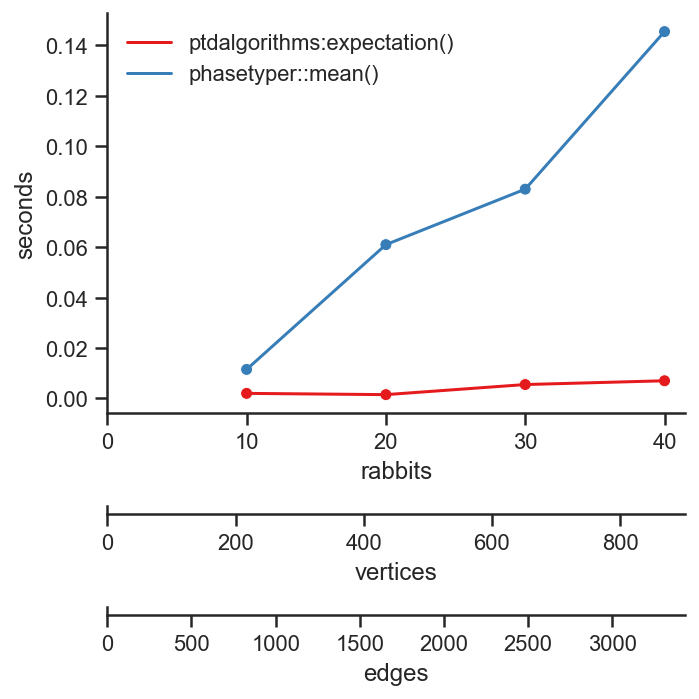

In [22]:
plot_df = (expectation_df.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': str(units[0]),
                  'ptdalgorithms_time': 'ptdalgorithms:expectation()', 
                  'phasetyper_time': 'phasetyper::mean()',
                  'matrixdist_time': 'matrixdist::moment()',
                  'matrixdist_inverse_time': 'matrixdist::inverse_matrix()',
                  'solve_time': 'base::solve()'
                 })
 .melt(id_vars=[things, 'vertices', 'edges'], 
       value_name='seconds', var_name='Method')
)
fig, axes = runtime_plot(plot_df, [str(units[0]), 'vertices', 'edges'],
                         'seconds', 'Method', legend_title=False)
for ax in axes:
    ax.set_xlim(left=0)
plt.savefig(f'figures/expectation_{str(label[0])}.pdf')

# 100 marginal expecations (phasetyper, ptdalgorithms)

We agree that matrixdist::inverse_matrix is a bit faster than base:solve on the examples used. This means that phasetyper (which uses base solve) could gain some speed by using matrixdist::inverse_matrix.

We compare to phasetyper below  as it offers the same same functionality as ptdalgoritms.

In [ ]:
%%R -o moments_100_df

moments_100_df <- data.frame()

for (i in 1:1) {   # PUT THIS BACK TO 1:10.......
    for (val in moments100_construction_values) {
        graph <- construction_fun(val)
        M <- graph_as_matrix(graph)
                
        phasetyper_time <- NA
        ptdalgorithms_time <- NA
        if (val <= moments100_max_construction_values_for_matrix) {

            # phasetyper
            Y <- PH(M$SIM, M$IPV)            
            rewards <- rep(1, length(M$IPV))
            start <- proc.time()[3]
            for (i in 1:100) {
               Y <- PhaseTypeR::reward_phase_type(Y, rewards)
               PhaseTypeR::mean(Y)
            }
            end <- proc.time()[3]
            phasetyper_time <- end - start                     
        }
        
        start <- proc.time()[3]
        rewards <- rep(1, length(rowSums(states(graph))))
        for (i in 1:100) {
           graph <- reward_transform(graph, rewards)
           expectation(graph)
        }
        end <- proc.time()[3]
        ptdalgorithms_time = end-start
        moments_100_df <- rbind(moments_100_df, list(val=val, 
                                                     ptdalgorithms_time=ptdalgorithms_time, 
                                                     phasetyper_time=phasetyper_time,
                                                     vertices=vertices_length(graph), 
                                                     edges=number_of_edges(graph)))
    }
}

In [ ]:
plot_df = (moments_100_df.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': str(units[0]),
                  'ptdalgorithms_time': 'ptdalgorithms:expectation()', 
                  'phasetyper_time': 'phasetyper::mean()',
                  'matrixdist_time': 'matrixdist::moment()',
                  'matrixdist_inverse_time': 'matrixdist::inverse_matrix()',
                  'solve_time': 'base::solve()'
                 })
 .melt(id_vars=[things, 'vertices', 'edges'], 
       value_name='seconds', var_name='Method')
)
fig, axes = runtime_plot(plot_df, [str(units[0]), 'vertices', 'edges'],
                         'seconds', 'Method', legend_title=False)
for ax in axes:
    ax.set_xlim(left=0)
plt.savefig(f'figures/moments_100_{str(label[0])}.pdf')

# Distribution (CDF 100 vals)

In [ ]:
%%R -o both_distribution_functions

cdf_vals <- seq(from = 0.1, to = 10, by = 0.1)


results <- data.frame()
for (i in 1:1) {   # PUT THIS BACK TO 1:10.......
    for (val in cdf100_construction_values){
        
            phasetyper_time <- NA
            ptdalgorithm_time <- NA
        
            graph <- construction_fun(val)
            start <- proc.time()[3]
            ptdcdf <- ptdalgorithms::pph(cdf_vals, graph)
            stop <- proc.time()[3]
            ptdalgorithm_time <- stop - start
        
            if (val <= cdf100_max_construction_values_for_matrix) {
                 M <- graph_as_matrix(graph)

                start <- proc.time()[3]
                Y <- PhaseTypeR::PH(M$SIM, M$IPV)
                PhaseTypeR::pPH(cdf_vals, Y)
                stop <- proc.time()[3]
                phasetyper_time <- stop - start

                # matrixdist_ph <- ph(M$IPV, M$SIM)
                # start <- proc.time()[3]
                # mdcdf <- matrixdist::cdf(matrixdist_ph, cdf_vals)
                # stop <- proc.time()[3]
                # matrixdist_time <- stop - start

                # SIM <- M$SIM
                # start <- proc.time()[3]
                # expm::expm(SIM, method="Higham08.b")
                # stop <- proc.time()[3]
                # expm_time <- stop - start           
            }


            results <- rbind(results, list(val=val, 
                                                     ptdalgorithm_time=ptdalgorithm_time,
                                                     phasetyper_time=phasetyper_time,
                                                     # matrixdist_time=matrixdist_time,
                                                     # expm_time=expm_time,
                                                     vertices=vertices_length(graph), 
                                                     edges=number_of_edges(graph)))
    }
}
both_distribution_functions <- results

In [ ]:
plot_df = (both_distribution_functions.groupby(['val', 'vertices', 'edges'])
 .agg('mean') 
 .reset_index()
 .rename(columns={'val': str(units[0]),
                  'ptdalgorithms_time': 'ptdalgorithms:expectation()', 
                  'phasetyper_time': 'phasetyper::mean()'})
 .melt(id_vars=[things, 'vertices', 'edges'], 
       value_name='seconds', var_name='Method')
)
fig, axes = runtime_plot(plot_df, [str(units[0]), 'vertices', 'edges'],
                         'seconds', 'Method', legend_title=False)
for ax in axes:
    ax.set_xlim(left=0)
#plt.savefig(f'figures/both_distribution_functions_{label}.pdf')

In [ ]:
%%R
rabbits <- 10
graph <- construct_rabbit_graph(rabbits, 2, 4)
x <- seq(from = 0.1, to = 10, by = 0.1)
ptdcdf <- ptdalgorithms::pph(x, graph)
qplot(x, ptdcdf)